# Loading in the training data names and all the masks
Test Markdown Cell

In [1]:
import numpy as np
import random
import sklearn
import pandas as pd
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
dsb_data_dir = os.path.join('.', 'input')
stage_label = 'stage1'

#Make plots inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#Autoreload external python modules
%load_ext autoreload
%autoreload 2

#Loading method from https://www.kaggle.com/kmader/nuclei-overview-to-submission/notebook
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
train_labels.sample(3)


,ImageId,EncodedPixels
24051,cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3...,"[367650, 8, 368252, 10, 368854, 12, 369456, 13..."
15644,7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2...,"[59792, 8, 60044, 14, 60297, 18, 60551, 21, 60..."
3122,193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a...,"[237001, 11, 237518, 17, 238036, 21, 238555, 2..."


In [2]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_test = lambda in_path: in_path.split('\\')[0]
img_id = lambda in_path: in_path.split('\\')[-3]
img_type = lambda in_path: in_path.split('\\')[-2]
img_group = lambda in_path: in_path.split('\\')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('\\')[-4].split('_')[0]

img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
3997,.\input\stage1_train\1d4a5e729bb96b08370789cad...,1d4a5e729bb96b08370789cad0791f6e52ce0ffe1fcc97...,masks,train,stage1
2812,.\input\stage1_train\150b0ffa318c87b31d78af0e8...,150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8...,masks,train,stage1


In [3]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

Wall time: 53.4 s


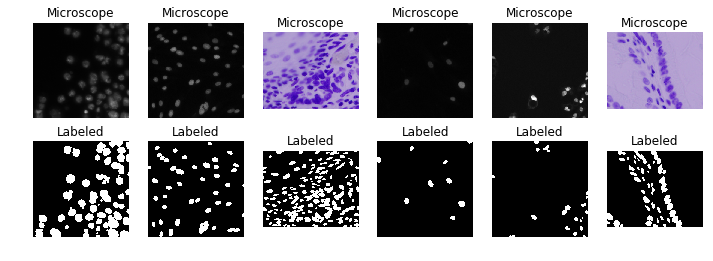

In [9]:
n_img = 6
fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.sample(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

In [13]:
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []

group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
test_img_df.sample(1)

,ImageId,Stage,images
1,0999dab07b11bc85fb8464fc36c947fbd8b5d6ec498173...,stage1,"[[[0.078431372549, 0.078431372549, 0.078431372..."


(6, 3)


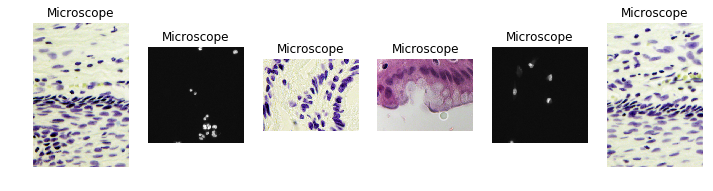

In [71]:
n_img = 6

fig, m_axs = plt.subplots(1, n_img, figsize = (12,4))
print(test_img_df.sample(n_img).shape)

for (_, c_row),(c_im) in zip(test_img_df.sample(n_img).iterrows(),m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis("off")
    c_im.set_title('Microscope')
    

Text(0.5,0,'Pixel Intensity')

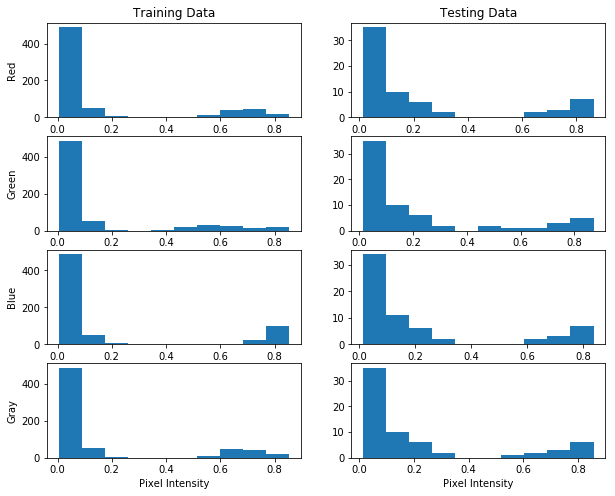

In [99]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Std'] = train_img_df['images'].map(lambda x: np.std(x))

test_img_df['Red'] = test_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
test_img_df['Green'] = test_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
test_img_df['Blue'] = test_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
test_img_df['Gray'] = test_img_df['images'].map(lambda x: np.mean(x))
test_img_df['Std'] = test_img_df['images'].map(lambda x: np.std(x))

plt.figure(1)
plt.subplot(4,2,1)
plt.hist(train_img_df['Red'])
plt.title('Training Data') 
plt.ylabel('Red')

plt.subplot(4,2,2)
plt.hist(test_img_df['Red'])
plt.title('Testing Data')

plt.subplot(4,2,3)
plt.hist(train_img_df['Green'])
plt.ylabel('Green')

plt.subplot(4,2,4)
plt.hist(test_img_df['Green'])

plt.subplot(4,2,5)
plt.hist(train_img_df['Blue'])
plt.ylabel('Blue')

plt.subplot(4,2,6)
plt.hist(test_img_df['Blue'])

plt.subplot(4,2,7)
plt.hist(train_img_df['Gray'])
plt.ylabel('Gray')
plt.xlabel('Pixel Intensity')

plt.subplot(4,2,8)
plt.hist(test_img_df['Gray'])
plt.xlabel('Pixel Intensity')


Text(0,0.5,'Pixel Intensity')

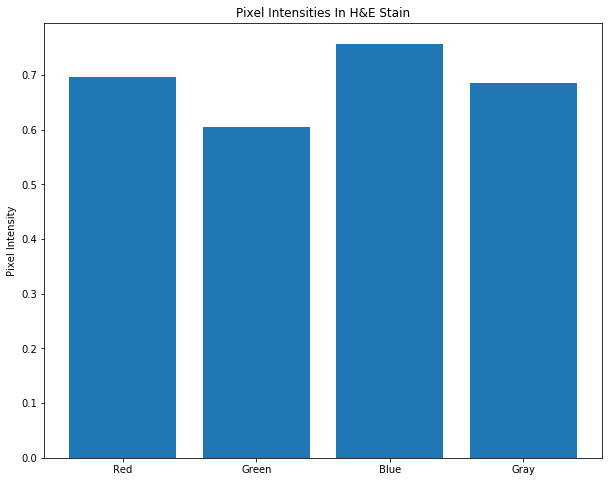

In [139]:
#Picking out a specific image to look at the color intensities of the image
#Looking at a H&E stain
selected_image = train_img_df.query('ImageId=="00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e"')
bar_graph_selected_image = (selected_image['Red'].values,selected_image['Green'].values,
                            selected_image['Blue'].values,selected_image['Gray'].values)
bar_graph_selected_image = np.concatenate(bar_graph_selected_image)
ind = np.arange(4)
plt.figure()
plt.bar(ind,bar_graph_selected_image)
plt.title('Pixel Intensities In H&E Stain')
plt.xticks(ind, ('Red', 'Green', 'Blue', 'Gray'))
plt.ylabel('Pixel Intensity')
#test_img_df.query('')

#Looking at fluorescent stain

In [33]:
#Taken from https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(train_img_df['Gray'])
mask = np.where(train_img_df['Gray'] > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)


In [14]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 156 separate components / objects detected.


In [15]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 669 1


In [21]:
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    

test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
#print(test_img_df.shape[0], 'images to process')
test_img_df.sample(1)

#for n-rows in test_df:
#    knn.fit(training_img_df)

,ImageId,Stage,images
16,31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab...,stage1,"[[[0.0549019607843, 0.0549019607843, 0.0549019..."


In [44]:
import pandas as pd
import pathlib
import imageio
import numpy as np
from skimage.color import rgb2gray

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [75]:
testing = pathlib.Path('.\\input\\stage1_test\\').glob('*\\images\\*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)

D:\Anaconda\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [74]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_red = np.mean(im[:,:,0])
    im_green = np.mean(im[:,:,1])
    im_blue = np.mean(im[:,:,2])
    im_gray = rgb2gray(im)

    img = im_gray
    radius = 1
    selem = disk(radius)

    local_otsu = rank.otsu(img, selem)    
    thresh_val_gray = threshold_otsu(im_gray)
    
    
    mask_gray = np.where(img >= local_otsu, 1, 0)
    
    if np.sum(mask_gray==0) < np.sum(mask_gray==1):
        mask_gray = np.where(mask_gray, 0, 1)    
        labels, nlabels = ndimage.label(mask_gray)
    labels, nlabels = ndimage.label(mask_gray)
    
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)        
        
    return im_df
